In [25]:
import os
import subprocess
import time
import pickle

import numpy as np

from matplotlib import pyplot as plt

import random
%matplotlib inline

In [2]:
import cv2

In [27]:
class Env:
    def __init__(self):
        self.restart_btn_img = cv2.imread('./restart_button.png', cv2.IMREAD_GRAYSCALE)
        self.action_space = range(20)
        self.dist_space = np.linspace(300, 1000, len(self.action_space))
    
    def __jump(self, distance):
        touch_x = random.randrange(300, 900)
        touch_y = random.randrange(300, 900)
        subprocess.call(".\\adb\\adb shell input swipe %d %d %d %d %d" % (touch_x, touch_y, touch_x, touch_y, distance))
        time.sleep(distance / 1000 + 2)
        
        
    def __capture_img(self, filename):
        subprocess.call('.\\adb\\adb shell /system/bin/screencap -p /sdcard/screenshot.png')
        time.sleep(0.1)
        subprocess.call('.\\adb\\adb pull /sdcard/screenshot.png %s' % filename)
        time.sleep(0.1)

        
    def __find_restart_btn(self, screen_shot_im):
        result = cv2.matchTemplate(screen_shot_im,
                                   self.restart_btn_img,
                                   cv2.TM_CCOEFF_NORMED)
        if result.max() > 0.8:
            y,x = np.unravel_index(result.argmax(),result.shape)
            y += self.restart_btn_img.shape[0] // 2
            x += self.restart_btn_img.shape[1] // 2
            return x, y
        else:
            return -1, -1
        
    def __to_state(self, screen_shot_im):
        return np.expand_dims(cv2.resize(screen_shot_im, (120, 200)) / 255.0,-1)
    
    
    def dist(self, action):
        d = action * 400 + 700
        if d < 300:
            d = 300
        elif d > 1100:
            d = 1100
            
        return d
        
        
    def reset(self):
        self.__capture_img('./tmp/screenshot.png')
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        btn_x, btn_y = self.__find_restart_btn(im)
        
        # The game has not ended yet
        if btn_x == -1:
            # Kill self
            self.__jump(1500)
            self.__capture_img('./tmp/screenshot.png')
            im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
            btn_x, btn_y = self.__find_restart_btn(im)
            
            assert btn_x != -1
                
        subprocess.call('.\\adb\\adb shell input tap %d %d' % (btn_x, btn_y))
        time.sleep(0.5)

        self.__capture_img('./tmp/screenshot.png')
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        btn_x, btn_y = self.__find_restart_btn(im)

        assert btn_x == -1
        
        return self.__to_state(im)
        
        
    def step(self, action):
        '''
        action: touch time(milliseconds)
        return: 
        '''
        time.sleep(0.5)
        
        dist = self.dist(action)
        self.__jump(dist)
        
        self.__capture_img('./tmp/screenshot.png')
        
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        
        btn_x, btn_y = self.__find_restart_btn(im)
        
        # The game has not ended yet
        if btn_x == -1:
            state = self.__to_state(im)
            reward = 1
            done = False
            return state, reward, done
        else:
            state = None
            reward = -1
            done = True
            return state, reward, done
        

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2328561511164048493
]


In [5]:
from keras.layers import *
from keras.models import Model,load_model,Sequential
from keras.callbacks import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
from keras.initializers import VarianceScaling
import keras.backend as K
from keras.applications.resnet50 import identity_block, conv_block

Using TensorFlow backend.


In [6]:
import tensorflow as tf

In [7]:
class ActorNetwork(object):
    def __init__(self, sess, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        K.set_session(sess)

        #Now create the model
        self.model , self.weights, self.state = self.create_actor_network()   
        self.target_model, self.target_weights, self.target_state = self.create_actor_network() 
        self.action_gradient = tf.placeholder(tf.float32,[None, 1])
        self.params_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(LEARNING_RATE).apply_gradients(grads)
        self.sess.run(tf.initialize_all_variables())

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads
        })

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self):
        inputs = Input(shape=(200,120,1))
        
        def Slice():
            def func(x):
                return x[:,50:170,:,:] - 0.5
            return Lambda(func)
        
        x = Slice()(inputs)
        
        x = AveragePooling2D((3,3),strides=(2,2), padding='same')(x)

        x = Conv2D(32, (8, 8), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (4, 4), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (3, 3), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Flatten()(x)
        x = Dense(200, activation='relu')(x)
        x = Dense(200, activation='relu')(x)

        outputs = Dense(1, activation='tanh',
                        kernel_initializer=VarianceScaling(scale=1e-4, mode='fan_in', distribution='normal', seed=None))(x)
        model = Model(inputs, outputs)
        model.compile(loss='mean_squared_error', optimizer=Adam(lr=self.LEARNING_RATE))

        return model, model.trainable_weights, inputs

In [8]:
class CriticNetwork(object):
    def __init__(self, sess, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE
        
        K.set_session(sess)

        #Now create the model
        self.model, self.state, self.action = self.create_critic_network()  
        self.target_model, self.target_state, self.target_action = self.create_critic_network()  
        self.action_grads = tf.gradients(self.model.output, self.action)  #GRADIENTS for policy update
        self.sess.run(tf.initialize_all_variables())

    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self):
        state_inputs = Input(shape=(200,120,1))
        
        def Slice():
            def func(x):
                return x[:,50:170,:,:] - 0.5
            return Lambda(func)
        
        x = Slice()(state_inputs)
        
        x = AveragePooling2D((3,3),strides=(2,2), padding='same')(x)

        x = Conv2D(32, (8, 8), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (4, 4), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (3, 3), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Flatten()(x)
        x_s = Dense(200, activation='relu')(x)
        
        action_inputs = Input(shape=(1,))
        x_a = Dense(200, activation='relu')(action_inputs)
        
        x = Add()([x_s,x_a])

#         x_a = Dense(128, activation='relu')(action_inputs)
        
#         x = Concatenate()([x_s,x_a])
        x = Dense(200)(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        outputs = Dense(1, activation='linear',
                       kernel_initializer=VarianceScaling(scale=1e-4, mode='fan_in', distribution='normal', seed=None))(x)
        
        model = Model([state_inputs, action_inputs], outputs)
        model.compile(loss='mean_squared_error', optimizer=Adam(lr=self.LEARNING_RATE))
 
        return model, state_inputs, action_inputs 

In [9]:
class OU(object):

    def function(self, x, mu, theta, sigma):
        return theta * (mu - x) + sigma * np.random.randn(1)[0]
    
OU = OU()

In [10]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.memory = []
        
        self.GAMMA = 0.99
        self.TAU = 0.001     #Target Network HyperParameters
        self.LRA = 0.0001    #Learning rate for Actor
        self.LRC = 0.001     #Lerning rate for Critic

        self.episode_count = 2000
        self.max_steps = 100000
        self.reward = 0
        self.done = False
        self.step = 0
        self.epsilon = 1
        self.epsilon_decay = .99
        self.epsilon_min = 0.1
        self.indicator = 0

        #Tensorflow GPU optimization
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config)
        K.set_session(self.sess)
        
        self.BATCH_SIZE = 32
        
        self.mem_len = 200

        self.actor = ActorNetwork(self.sess, self.BATCH_SIZE, self.TAU, self.LRA)
        self.critic = CriticNetwork(self.sess, self.BATCH_SIZE, self.TAU, self.LRC)
        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        
    def act(self, state):
        act = self.actor.model.predict_on_batch(np.expand_dims(state,0))[0][0]
        
        noise = self.epsilon * OU.function(act, 0, 0.5, 0.5)
        
        print('act:',act,'noise:',noise,'sum:',act+noise)
        
        return act + noise
    
    
    def replay(self):
        if len(self.memory) < 64:
            self.mem_len = 32
        elif len(self.memory) < 128:
            self.mem_len = 64
        elif len(self.memory) < 256:
            self.mem_len = 128
        elif len(self.memory) < 512:
            self.mem_len = 256
        else:
            self.mem_len = 512
        
        mem = self.memory[-self.mem_len:]
        
        n_batch = min(self.BATCH_SIZE, len(mem))
        batches = np.random.choice(len(mem), n_batch)
        
        states = []
        actions = []
        rewards = []
        new_states = []
        dones = []
        
        for i,mem_idx in enumerate(batches):
            state, action, reward, next_state, done = mem[mem_idx]
            
            if done:
                next_state = np.zeros_like(state)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            new_states.append(next_state)
            dones.append(done)
        
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        new_states = np.array(new_states)

        target_q_values = self.critic.target_model.predict_on_batch(
            [new_states, self.actor.target_model.predict_on_batch(new_states)])
        
        y_t = []
        
        for k,d in enumerate(dones):
            if d:
                y_t.append(rewards[k])
            else:
                y_t.append(rewards[k] + self.GAMMA*target_q_values[k])
                
        y_t = np.array(y_t)
        
        loss = self.critic.model.train_on_batch([states,actions], y_t) 
        a_for_grad = self.actor.model.predict_on_batch(states)
        grads = self.critic.gradients(states, a_for_grad)
        self.actor.train(states, grads)
        self.actor.target_train()
        self.critic.target_train()
        
        return loss

In [11]:
episodes = 1000

# 为agent初始化gym环境参数
env = Env()

(array([  61.,   59.,   86.,  150.,  152.,  167.,  126.,   81.,   69.,   49.]),
 array([  300.,   380.,   460.,   540.,   620.,   700.,   780.,   860.,
          940.,  1020.,  1100.]),
 <a list of 10 Patch objects>)

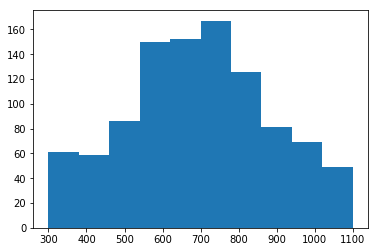

In [12]:
plt.hist([env.dist(i) for i in list(np.random.randn(1000) * 0.5)])

In [13]:
agent = Agent(env)
agent.actor.model.summary()
agent.critic.model.summary()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 120, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 120, 120, 1)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        2080      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        16416     
_________________________________________________________________
ac

In [16]:
scores = []
e = 0

In [1]:

# 游戏的主循环
while e < episodes:

    # 在每次游戏开始时复位状态参数
    state = env.reset()

    # time_t 代表游戏的每一帧
    # time_t 越大，分数越高
    
    loss = 0
    for time_t in range(10000):
        
        # turn this on if you want to render
        # env.render()

        # 选择行为
        action = agent.act(state)

        # 在环境中施加行为推动游戏进行
        next_state, reward, done = env.step(action)
        
        print('jump dist:', env.dist(action))

        # 记忆先前的状态，行为，回报与下一个状态
        agent.remember(state, action, reward, next_state, done)

        # 使下一个状态成为下一帧的新状态
        state = copy.deepcopy(next_state)
        
        loss += agent.replay()

        # 如果游戏结束done被置为ture
        # 除非agent没有完成目标
        if done:
            # 打印分数并且跳出游戏循环
            print("episode: {}/{}, score: {}"
                  .format(e, episodes, time_t))
            scores.append(time_t)
            break
    
    loss /= (time_t+1)
    
    print('mem:', len(agent.memory), 'epsilon:', agent.epsilon, 'loss:', loss)
        
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
        
    e += 1

NameError: name 'e' is not defined

In [69]:
# 游戏的主循环
test_scores = []
for i in range (10):

    # 在每次游戏开始时复位状态参数
    state = env.reset()

    # time_t 代表游戏的每一帧
    # time_t 越大，分数越高
    
    loss = 0
    for time_t in range(10000):
        
        # turn this on if you want to render
        # env.render()

        # 选择行为
        action = agent.actor.model.predict_on_batch(np.expand_dims(state,0))[0][0]

        # 在环境中施加行为推动游戏进行
        next_state, reward, done = env.step(action)
        
        state = copy.deepcopy(next_state)
        
        print('jump dist:', env.dist(action))

        # 如果游戏结束done被置为ture
        # 除非agent没有完成目标
        if done:
            # 打印分数并且跳出游戏循环
            print("episode: {}/{}, score: {}"
                  .format(i, episodes, time_t))
            test_scores.append(time_t)
            break
    

jump dist: 778.057390451
jump dist: 801.948833466
jump dist: 473.002028465
jump dist: 425.69642067
jump dist: 598.067045212
jump dist: 819.951462746
jump dist: 821.070337296
jump dist: 493.02945137
jump dist: 772.478765249
episode: 16/1000, score: 8
jump dist: 736.160233617
jump dist: 559.084653854
jump dist: 656.446427107
jump dist: 393.248009682
jump dist: 829.429554939
episode: 16/1000, score: 4
jump dist: 722.354635596
jump dist: 620.169955492
jump dist: 436.751270294
jump dist: 532.452988625
jump dist: 563.821542263
jump dist: 632.59678483
jump dist: 430.170154572
jump dist: 889.445447922
jump dist: 547.043442726
jump dist: 417.805409431
jump dist: 449.823284149
jump dist: 737.299671769
jump dist: 934.500980377
jump dist: 392.527914047
jump dist: 709.617038071
episode: 16/1000, score: 14
jump dist: 773.95388484
jump dist: 857.915747166
jump dist: 786.722296476
jump dist: 743.442317843
jump dist: 579.36309576
episode: 16/1000, score: 4
jump dist: 729.306274652
jump dist: 722.761465

In [71]:
np.average(test_scores)

10.6

In [56]:
# at 235 episode

agent.actor.TAU = 0.5
agent.critic.TAU = 0.5

In [63]:
# at 272 episode

agent.actor.TAU = 0.25
agent.critic.TAU = 0.25

In [75]:
pickle.dump(agent.memory,open('./tmp/ddpg_mem.m','wb'))

In [76]:
agent.actor.model.save_weights('./tmp/ddpg_actor.w')
agent.actor.target_model.save_weights('./tmp/ddpg_tactor.w')
agent.critic.model.save_weights('./tmp/ddpg_critic.w')
agent.critic.target_model.save_weights('./tmp/ddpg_tcritic.w')

In [55]:
pickle.dump(scores,open('./tmp/ddpg_scores.p','wb'))

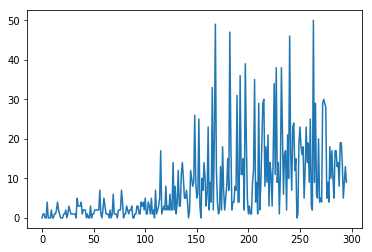

In [73]:
plt.plot(range(len(scores)),scores)

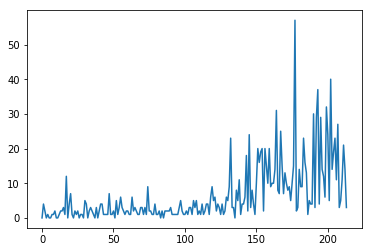

In [24]:
plt.plot(range(len(scores)),scores)

In [74]:
len(scores)

296

In [110]:
ag1 = Agent(env)
ag1.memory = agent.memory
ag1.actor.model.summary()
ag1.critic.model.summary()

ag1.actor.TAU = 0.001
ag1.critic.TAU = 0.001

for i in range(50):
    loss = 0
    for i in range(50):
        loss += ag1.replay()
    print(loss / 50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        (None, 200, 120, 1)       0         
_________________________________________________________________
lambda_56 (Lambda)           (None, 120, 120, 1)       0         
_________________________________________________________________
average_pooling2d_56 (Averag (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 30, 30, 32)        2080      
_________________________________________________________________
activation_139 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 15, 15, 32)        16416     
_________________________________________________________________
activation_140 (Activation)  (None, 15, 15, 32)        0         
__________

KeyboardInterrupt: 

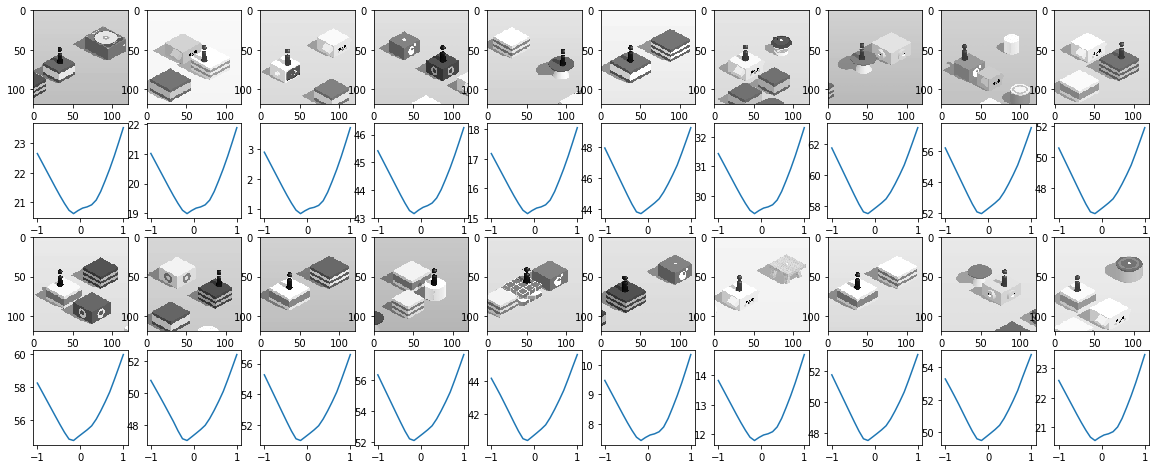

In [108]:
f, axes = plt.subplots(4,10,figsize=(20,8))

for i in range(4):
    for j in range(10):
        if i % 2 == 0:
            state = random.choice(ag1.memory)[0]
            pic = state[50:170,:,0]
            axes[i][j].imshow(pic, cmap='gray')
            
            action_space = np.linspace(-1,1,20)
            reward = np.zeros_like(action_space)
            for k in range(action_space.shape[0]):
                reward[k] = ag1.critic.target_model.predict_on_batch(
                    [np.expand_dims(state,0), np.expand_dims(np.expand_dims(action_space[k],0),0)])[0][0]
            axes[i+1][j].plot(action_space, reward)

In [52]:
agent.epsilon = 0.5
agent.epsilon_min = 0.15

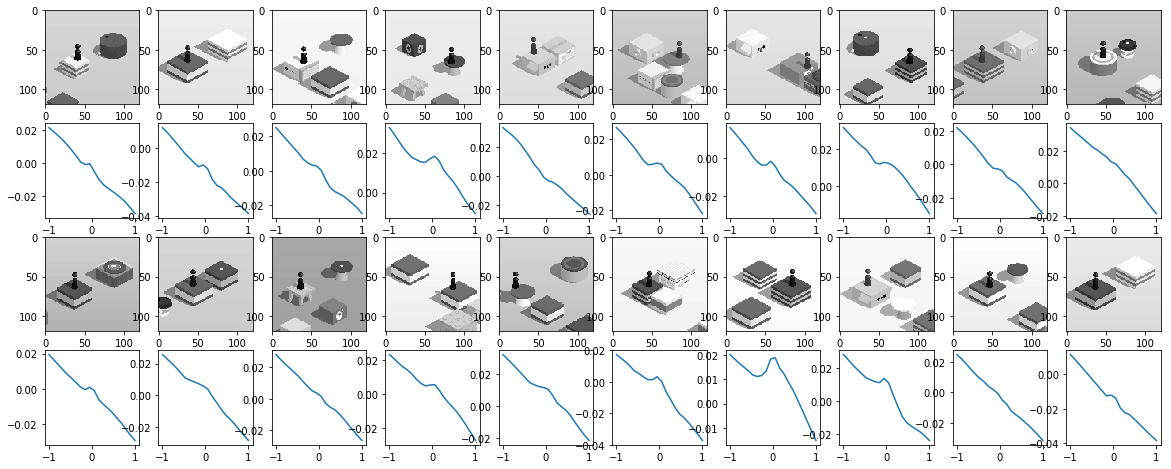

In [79]:
f, axes = plt.subplots(4,10,figsize=(20,8))

for i in range(4):
    for j in range(10):
        if i % 2 == 0:
            state = random.choice(agent.memory)[0]
            pic = state[50:170,:,0]
            axes[i][j].imshow(pic, cmap='gray')
            
            action_space = np.linspace(-1,1,20)
            reward = np.zeros_like(action_space)
            for k in range(action_space.shape[0]):
                reward[k] = agent.critic.target_model.predict_on_batch(
                    [np.expand_dims(state,0), np.expand_dims(np.expand_dims(action_space[k],0),0)])[0][0]
            axes[i+1][j].plot(action_space, reward)

In [70]:
agent.epsilon = 0.01

<Container object of 20 artists>

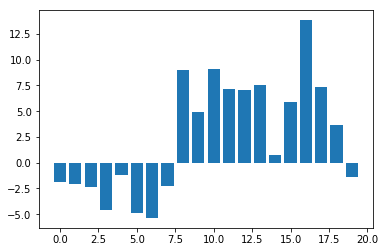

In [117]:
plt.bar(agent.env.action_space,agent.model.predict(np.expand_dims(agent.memory[][0],0))[0])

In [91]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(*args, **kwargs)
    Make a bar plot.
    
    Call signatures::
    
       bar(x, height, *, align='center', **kwargs)
       bar(x, height, width, *, align='center', **kwargs)
       bar(x, height, width, bottom, *, align='center', **kwargs)
    
    Make a bar plot with rectangles bounded by
    
    .. math::
    
       (x - width/2, x + width/2, bottom, bottom + height)
    
    (left, right, bottom and top edges) by default.  *x*,
    *height*, *width*, and *bottom* can be either scalars or
    sequences.
    
    The *align* and *orientation* kwargs control the interpretation of *x*
    and *bottom*
    
    The *align* keyword-only argument controls if *x* is interpreted
    as the center or the left edge of the rectangle.
    
    Parameters
    ----------
    x : sequence of scalars
        the x coordinates of the bars.
    
        *align* controls if *x* is the bar center (default) or
        left edge.
    
    heig

In [138]:
agent.model.save_weights('./tmp/weights.w')
pickle.dump(agent.memory, open('./tmp/memory.m','wb'))

In [68]:
min_loss = 1e10
min_pos = 0

for i in range(1000):
    loss = 0
    for i in range(50):
        l = agent.replay(32)
        loss += l
    print(loss / 50)
    
    if loss < min_loss:
        min_pos = i
        min_loss = loss
    
    if i - min_pos > 100:
        break

i

128.82689827
94.7225925446
37.4278962708
31.1282489967
15.9667807198
16.0796065235
14.0383515739
12.0921261883
11.2964262009
8.64634869099
7.35213395119
7.32252527714
6.3635424757
4.71984107256
4.57263987064
3.77086829185
4.77240906715
3.48491025209
9.52575344563
5.55766092539
4.55353834867
3.18393145323
2.79013663769
2.49263638139
3.06989862561
4.35556167364
2.88895393372
2.96023203969
3.11350908041
4.47541817427
3.99412070513


KeyboardInterrupt: 

In [58]:
i, min_pos

(228, 227)

In [178]:
agent.epsilon

0.20554993075174754